<a href="https://colab.research.google.com/github/hannape/IBAC-Biodiv/blob/master/FA_dorobienie_do_artyku%C5%82u_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jest to Kopia notatnika, Kopia notatnika powt_resNet_naFA_z_marca2020_moreRAM .ipynb. Trzeba przez kopie, bo problem z przydzieleniem ramu dla notatnika.kiedyś można było po skrashowaniu wziąć 25 zamias 12 GB, a teraz już nie ma takiej opcji. https://github.com/googlecolab/colabtools/issues/253

Oprócz tego, biorę kod z Copy of Transfer_learning_3types_Na FA2020 [2] z ph@, tam jest trenowanie również

In [ ]:
# as you can see current ram is 12GB only, to increase it run below code

In [11]:
from google.colab import drive
drive.mount('/content/drive')                       
from __future__ import print_function

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import matplotlib.pyplot as plt
from librosa.core import amplitude_to_db
!pip install pkgconfig libtfr
import libtfr
import librosa                                                      
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
import wave
import contextlib
import math
from torchvision import models
import torch.nn as nn
import calendar
import time
!pip install jupyter_beeper
import jupyter_beeper

# Wczytywanie Danych [2]

In [13]:
path_test1618 = 'drive/My Drive/testowe_1618/'

def my_check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
 ''' 
    
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    
    return (float(labels[0]) >= second and float(labels[0]) < second + 0.5 - tol) or \
           (float(labels[1]) < second + 0.5 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 0.5) and (labels[2] in calls_to_cut)


def my_read_labels(label_name,path_test1618):
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join(path_test1618, label_name + '.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[0:]:
            if len(line) > 1:
                start, stop, spec = line.split('\t')
                #print(start)
                start, stop, spec = float(start), float(stop), str(spec),
                labels.append([start, stop, spec])
    return np.array(labels)

  
def my_map_seconds_to_y(labels, recording_duration):  ## Chcemy 500 ms z 150 ms overlapem
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    
    
    chunk_length_ms = 500
    chunk_overlap = 150
    duration_in_ms = recording_duration*1000
    nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)
    #print("chunksy!!")
    #print(nr_of_chunks)
    
    
    y = [0] * math.ceil(nr_of_chunks) #recording_duration 
    y_restrictive = [0] * math.ceil(nr_of_chunks) #* recording_duration
    for s in range(math.ceil(nr_of_chunks)):
        for l in labels:
            if my_check_voices(s*0.35, l):
                y[s] = 1
                #print(s*0.35)
                if l[2] in calls_to_cut:
                  y[s] = 0
                 # print("Labele1: " + l[2]) 
            if my_check_voices(s*0.35, l, 0.004): # 0.02
                y_restrictive[s] = 1
                if l[2] in calls_to_cut:
                  y_restrictive[s] = 0
                  #print("wyciety glos:")
                  #print(l[2])
                  
                 # print("Labele2: " + l[2]) 
        if y[s] != y_restrictive[s]:
            y[s] = 0 # -1 jeśli mniej niż 4 ms fragment, to zakładamy że tam go nie ma...          
   
    return y
  
  
def my_load_test(a,the_same_3layers):
    '''Wczytuje dane testowe, moje, długie nagrania.

    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.

    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    max_freq = 64
    max_time  = 149
    X_train, y_train = [], []
    samples, sample_rate2 = [], []
    rec_files = [file_name for file_name in sorted(os.listdir(path_test1618)) if file_name.endswith('.wav')]
    rep_names = [my_load_spec, my_load_mel, my_load_multitap]
    file_name=rec_files[a]

    recording_id = (file_name.split('.')[0])
    print("------------Analiza nagrania: " + file_name + "-----------")
    fname = path_test1618 + file_name
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        recording_duration = math.ceil(duration)
        print("Czas trwania - w sekundach: " + str(recording_duration))

    recording_labels = my_read_labels(recording_id,path_test1618)
    y_binary = my_map_seconds_to_y(recording_labels, duration)

  
    samples, sample_rate2 = librosa.core.load(fname, sr = None)

    '''
    for i, y in enumerate(y_binary):
        if y != -1:
            try:
                representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050)# start = i, stop = i + 1)
                if (i%5000==0):
                  end_time = datetime.datetime.now()
                  print(end_time - start_time)
                  print(np.shape(X_train),np.shape(y_train))
                  start_time == end_time
                X_train.append(representation)
                y_train.append(y)
            except ValueError:
                print('Error reading file', file_name)
            except TypeError:
                print('Unsupported type', file_name)
    print(np.shape(X_train),np.shape(y_train)) 

 tak bylo przed chwilo
        for i, y in enumerate(y_binary):
        repres=np.zeros((3, max_freq, max_time))
        
        for k in range(0,3):
          representation1 = rep_names[k](samples, start = i*15435 , stop = i*15435 + 22050)
          repres[k,:,:][:representation1.shape[0],:representation1.shape[1]] = representation1

        X_train.append(repres)
        y_train.append(y)
        if (i%2000==0):
          end_time = datetime.datetime.now()
          print(end_time - start_time)
          print(np.shape(X_train),np.shape(y_train))
          start_time == end_time
 
    '''
    for i, y in enumerate(y_binary):

      if (the_same_3layers==0):
        
        repres=np.zeros((3, max_freq, max_time))
        
        for k in range(0,3):
          representation1 = rep_names[k](samples, start = i*15435 , stop = i*15435 + 22050)
          repres[k,:,:][:representation1.shape[0],:representation1.shape[1]] = representation1

        X_train.append(repres)
        y_train.append(y)
        if (i%2000==0):
          end_time = datetime.datetime.now()
          print(end_time - start_time)
          print(np.shape(X_train),np.shape(y_train))
          start_time == end_time

      if (the_same_3layers==1):
        load_repr = my_load_mel
        representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050)
        if (i%2000==0):
          end_time = datetime.datetime.now()
          print(end_time - start_time)
          print(np.shape(X_train),np.shape(y_train))
          start_time == end_time
        X_train.append(representation)
        y_train.append(y)
        #X_train = np.stack(3*(X_train,), axis=1)
    

    #    
    return np.array(X_train), np.array(y_train)

In [14]:
f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maksymalna częstotliwość analizowana ze spektro

def my_stop_start(samples,start, stop,sample_rate = 44100):

  if(stop>np.shape(samples)[0]):
    stop = np.shape(samples)[0]
    print((stop-start)/sample_rate)

  samples = samples[int(start):int(stop) if stop else None]

  if(np.shape(samples)[0] < sample_rate/2):
    diff = sample_rate/2 - np.shape(samples)[0]
    samples = np.pad(samples, (0,int(diff)), 'constant', constant_values=(0))

  return samples, stop

def my_load_mel(samples, start=0, stop=None,sample_rate = 44100 ):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    n_mels= 64 ## -------------------------------------------------------------------- ZMIANA ze 128
    
    samples, stop = my_stop_start(samples,start, stop)
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate, n_fft=512, hop_length = 150,
                                                   n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

def my_load_spec(samples, start=0, stop=None,sample_rate = 44100):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, stop = my_stop_start(samples,start, stop)
    stft = librosa.stft(samples, n_fft=512, win_length=512, hop_length=150, window= "hann") #scipy.signal.get_window(('gaussian',50) ,512) )#scipy.signal.gaussian(512, 2)   ) 
    stft1 = amplitude_to_db(np.abs(stft)**2)
    freqs = librosa.core.fft_frequencies(n_fft=512, sr=44100)
    fmin =  min(freqs[(freqs >= f_min)])
    i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
    j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
    spectrogram = stft1[min(i):max(j),] 

    return spectrogram

def my_load_multitap(samples, start=0, stop=None,sample_rate = 44100):

    samples, stop = my_stop_start(samples,start, stop)
    result5 = libtfr.tfr_spec(samples, N = 512, step = 145, Np = 490, K = 2, tm = 1, flock =0.1, tlock = 10)     
    freqs, ind = libtfr.fgrid(sample_rate, 512, fpass=(4000,9500)) 
    spectrogram = result5[ind,];

    return spectrogram


def my_load_train(the_same_3layers): 
  path_train161718 = 'drive/My Drive/treningowe94_161718/'
  X_train, y_train = [], []

  rec_files = [file_name for file_name in os.listdir(path_train161718) if file_name.endswith('.wav')]
  years = ['2016','2017','2018']
  files_sorted = []

  for year in years:
    i_201x = [i for i,s in enumerate(rec_files) if year in s]
    n_201x = sorted(rec_files[index] for index in i_201x)
    files_sorted = files_sorted + n_201x

  print(files_sorted)
  rok = "6"
  max_freq = 64
  max_time = 149
  for file_name in files_sorted:
      
      print("------------Analiza nagrania: " + file_name + "-----------")
      recording_id = str(file_name.split('.')[0])
      if (file_name=="BUK4_20171001_020404a.wav"):
        rok = "7"
      if (file_name=="BUK4_20181029_235604.wav"):
        rok = "8"  
      source_npz = "/content/drive/My Drive/nobirds_chunks/repr7_201" + rok + "/"
      ## wczytanie plików, skąd można wziąc nr próbek losowych do balanced dataset
      dane1 = np.load(source_npz + 'Kopia '+ recording_id + '_7rep.npz' )
      nobirds_chunks = dane1["nobirds_chunks"] 
      print(np.shape(nobirds_chunks)) 
      
      fname = path_train161718 + file_name
      print(fname)
      with contextlib.closing(wave.open(fname,'r')) as f:
          frames = f.getnframes()
          rate = f.getframerate()
          duration = frames / float(rate)
          recording_duration = math.ceil(duration)
          print("Czas trwania - w sekundach: " + str(recording_duration))
    
      recording_id = (file_name.split('.')[0])
      print(recording_id)
      recording_labels = my_read_labels(recording_id, path_train161718)

      y_binary = my_map_seconds_to_y(recording_labels, duration)
      rep_names = [my_load_spec,my_load_mel, my_load_multitap]
      
      samples, sample_rate2 = librosa.core.load(fname, sr = None)

      #max_freq = max(np.shape(representation1)[0],np.shape(representation2)[0],np.shape(representation3)[0])
      #max_time = max(np.shape(representation1)[1],np.shape(representation2)[1],np.shape(representation3)[1])
      #print(max_freq, max_time)
      print(np.shape(y_binary))
      
      if (the_same_3layers==0):
        for i, y in enumerate(y_binary):
          
          repres=np.zeros((3, max_freq, max_time))
          if y == 1:
            for k in range(0,3):
              representation1 = rep_names[k](samples, start = i*15435 , stop = i*15435 + 22050)
              repres[k,:,:][:representation1.shape[0],:representation1.shape[1]] = representation1         
            X_train.append(repres)
            y_train.append(y)
        print(np.shape(X_train),np.shape(y_train))

        for i in nobirds_chunks:   
          repres=np.zeros((3, max_freq, max_time))
      
          for k in range(0,3):
            representation1 = rep_names[k](samples, start = i*15435 , stop = i*15435 + 22050)
            repres[k,:,:][:representation1.shape[0],:representation1.shape[1]] = representation1
          X_train.append(repres)
          y_train.append(y)


      if (the_same_3layers==1): 
        load_repr = my_load_mel
        for i, y in enumerate(y_binary):
            if y == 1:
              representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050) 
              X_train.append(representation)
              y_train.append(y)
        
        for i in nobirds_chunks:
              representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050)
              X_train.append(representation)
              y_train.append(y)   
      # rysowanie przykladowych reprezentacji
      '''if (the_same_3layers==0): 
        plt.subplot(1, 3, 1)
        plt.imshow(X_train[221][0,:,:], cmap="jet")  
        plt.subplot(1, 3, 2)
        plt.imshow(X_train[221][1,:,:], cmap="jet") 
        plt.subplot(1, 3, 3)
        plt.imshow(X_train[221][2,:,:], cmap="jet")  
      if (the_same_3layers==1):
        plt.subplot(1, 3, 1)
        plt.imshow(X_train[221], cmap="jet")
      '''
      print("Liczba no birds chunks: " + str(np.shape(nobirds_chunks)) + "Liczba positive chunks: " + str(sum(y_binary)))
      print(np.shape(X_train),np.shape(y_train))

  print("Final shape:")
  print(np.shape(X_train),np.shape(y_train))

  return np.array(X_train), np.array(y_train)

In [15]:
path_train161718 = 'drive/My Drive/treningowe94_161718/'
X_train, y_train = [], []

rec_files = [file_name for file_name in os.listdir(path_train161718) if file_name.endswith('.wav')]
print(rec_files[0:3])
years = ['2016','2017','2018']
files_sorted = []

for year in years:
  i_201x = [i for i,s in enumerate(rec_files) if year in s]
  n_201x = sorted(rec_files[index] for index in i_201x)
  files_sorted = files_sorted + n_201x

print(np.shape(files_sorted))

['BUK4_20161031_232104b.wav', 'BUK4_20161104_011504.wav', '4szum_sredni_BUK4_20160918_013604.wav']
(94,)


In [16]:
####################### !!!!!!!!!!!!
the_same_3layers = 1 # te same czy nie te same. ZMIENIAĆ

####################### !!!!!!!!!!!!!!!

In [17]:

X_train_new, y_train_new = my_load_train(the_same_3layers)  # zmiana na my !!!

print(X_train_new.shape)
print(y_train_new.shape)



['1swierszcze_nakladki_BUK4_20160925_204604.wav', '2koniec_swierszczy_BUK4_20160925_221604.wav', '3wzgledna_cisza_BUK4_20160925_224604.wav', '4szum_sredni_BUK4_20160918_013604.wav', '5szum_sredni_nakladki_BUK4_20161011_000804.wav', '6wichura_deszcz_BUK4_20161005_022304.wav', '7wiatr_BUK4_20161006_002104.wav', '8deszczk_bezptasio_BUK4_20161015_235704.wav', '9niski_szum_BUK4_20161025_000604.wav', 'BUK1_20160914_011604.wav', 'BUK4_20160918_223304.wav', 'BUK4_20160919_013304.wav', 'BUK4_20160925_191604.wav', 'BUK4_20160925_194604.wav', 'BUK4_20160925_201604.wav', 'BUK4_20160925_211604.wav', 'BUK4_20160925_214604.wav', 'BUK4_20160925_231604.wav', 'BUK4_20160925_234604.wav', 'BUK4_20160926_001604.wav', 'BUK4_20160926_004604.wav', 'BUK4_20160926_011604.wav', 'BUK4_20160926_014604.wav', 'BUK4_20160926_021604.wav', 'BUK4_20160926_024604.wav', 'BUK4_20160926_031604.wav', 'BUK4_20160926_034604.wav', 'BUK4_20161002_235805.wav', 'BUK4_20161005_012304.wav', 'BUK4_20161013_200104.wav', 'BUK4_20161019

# Model i Trenowanie

(12732,)
(12732, 64, 148)
Czy te same warstwy mają być? 1
torch.Size([12732])
torch.Size([12732, 3, 64, 148])
torch.Size([3184])
torch.Size([3184, 3, 64, 148])


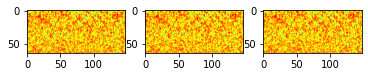

In [24]:
# Dzielenie zbioru danych na treningowy i walidacyjny
#split_point = int(len(X) * 0.8)
import sklearn
X_train1, X_val1, y_train1, y_val1 = sklearn.model_selection.train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=667)
print(np.shape(y_train1))
print(np.shape(X_train1))
# tego nie trzeba, bo juz mamy 3 reprezentacjie, nie potrajamy mel spekta

if (the_same_3layers==1):
  X_train2 = np.stack(3*(X_train1,), axis=1)
  X_val2 = np.stack(3*(X_val1,), axis=1)
  X_train = torch.Tensor(X_train2)
  X_valid = torch.Tensor(X_val2)
  
else:
  X_train = torch.Tensor(X_train1)
  X_valid = torch.Tensor(X_val1)

print("Czy te same warstwy mają być?", the_same_3layers)
plt.subplot(1, 3, 1)
plt.imshow(X_train[221][0,:,:], cmap="jet")  
plt.subplot(1, 3, 2)
plt.imshow(X_train[221][1,:,:], cmap="jet") 
plt.subplot(1, 3, 3)
plt.imshow(X_train[221][2,:,:], cmap="jet")    
# X_train = torch.Tensor(stacked_X_train1)
 #X[:split_point])
#X_train = torch.Tensor(X_train1) #X[:split_point])
y_train = torch.LongTensor(y_train1) #[:split_point])
print(np.shape(y_train))
print(np.shape(X_train))

#X_valid = torch.Tensor(stacked_X_val1) #[split_point:])
 #[split_point:])
y_valid = torch.LongTensor(y_val1) #[split_point:])
print(np.shape(y_valid))
print(np.shape(X_valid))
batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

Przygotowawcze. Opcje, definicje wczytywania




In [27]:


f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maksymalna częstotliwość analizowana ze spektro

def my_stop_start(samples,start, stop,sample_rate = 44100):

  if(stop>np.shape(samples)[0]):
    stop = np.shape(samples)[0]
    print((stop-start)/sample_rate)

  samples = samples[int(start):int(stop) if stop else None]

  if(np.shape(samples)[0] < sample_rate/2):
    diff = sample_rate/2 - np.shape(samples)[0]
    samples = np.pad(samples, (0,int(diff)), 'constant', constant_values=(0))

  return samples, stop

def my_load_mel(samples, start=0, stop=None,sample_rate = 44100 ):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    n_mels= 64 ## -------------------------------------------------------------------- ZMIANA ze 128
    
    samples, stop = my_stop_start(samples,start, stop)
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate, n_fft=512, hop_length = 150,
                                                   n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

def my_load_spec(samples, start=0, stop=None,sample_rate = 44100):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, stop = my_stop_start(samples,start, stop)
    stft = librosa.stft(samples, n_fft=512, win_length=512, hop_length=150, window= "hann") #scipy.signal.get_window(('gaussian',50) ,512) )#scipy.signal.gaussian(512, 2)   ) 
    stft1 = amplitude_to_db(np.abs(stft)**2)
    freqs = librosa.core.fft_frequencies(n_fft=512, sr=44100)
    fmin =  min(freqs[(freqs >= f_min)])
    i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
    j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
    spectrogram = stft1[min(i):max(j),] 

    return spectrogram

def my_load_multitap(samples, start=0, stop=None,sample_rate = 44100):

    samples, stop = my_stop_start(samples,start, stop)
    result5 = libtfr.tfr_spec(samples, N = 512, step = 145, Np = 490, K = 2, tm = 1, flock =0.1, tlock = 10)     
    freqs, ind = libtfr.fgrid(sample_rate, 512, fpass=(4000,9500)) 
    spectrogram = result5[ind,];

    return spectrogram

In [22]:
## NEW part
modelik = models.resnet18(pretrained=True)
modelik2 = models.resnet50(pretrained=True)
print('resnet18')
for name, child in modelik.named_children():
    print(name)

print('resnet50')    
for name, child in modelik2.named_children(): 
    print(name)   
print('----------------------------------------------------------------')
print('-------------->resnet18')
for child in modelik.children():    
    print(child)
print('----------------------------------------------------------------')

print('-------------->resnet50')
for child in modelik2.children():
    print(child)      

print(modelik)
print(modelik2)

resnet18
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
resnet50
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
----------------------------------------------------------------
-------------->resnet18
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

In [23]:
######### OPCJA 1 - inicjalizujemy wagami, ale uczymy całą sieć od nowa. Stosowane w przypadku gdy dużo dancyh, i gdy dane podobne do zbioru transferowanego
## ft: FINE - TUNING
## https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def opcja0():
  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features  # fc- fully connected, input features
  model_ft.fc = nn.Linear(num_ftrs, 2)
  return model_ft

######### OPCJA 2 - inicjalizujemy i zamrażamy wszystkie wagi oprócz ostatniej warstwy która będzie trenowana
def opcja1():
  feature_extract_last = models.resnet18(pretrained=True)
  for param in feature_extract_last.parameters():
      param.requires_grad = False

  num_ftrs = feature_extract_last.fc.in_features
  feature_extract_last.fc = nn.Linear(num_ftrs, 2)
  return feature_extract_last

######### OPCJA 3 - inicjalizujemy i zamrażamy wszystkie wagi oprócz kilku ostatnich warstw które będą retrenowane
# https://towardsdatascience.com/transfer-learning-picking-the-right-pre-trained-model-for-your-problem-bac69b488d16

def opcja2():
  feature_extract_few = models.resnet18(pretrained=True)
  count = 0
  for name, child in feature_extract_few.named_children():
      if name in ['layer3', 'layer4']:
          #print(name + ' has been unfrozen.')
          for param in child.parameters():
              param.requires_grad = True
      else:
          for param in child.parameters():
              param.requires_grad = False

  num_ftrs = feature_extract_few.fc.in_features
  feature_extract_few.fc = nn.Linear(num_ftrs, 2)
  return feature_extract_few

  ######### OPCJA 4 - inicjalizujemy i zamrażamy pierwszą warstwę, reszta retrenowane
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://towardsdatascience.com/transfer-learning-picking-the-right-pre-trained-model-for-your-problem-bac69b488d16
# https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/#fixedfeatureextractor

def opcja3():
  feature_extract_first = models.resnet18(pretrained=True)

  count = 0
  for name, child in feature_extract_first.named_children():
      if name in ['layer2','layer3', 'layer4']:
          #print(name + ' has been unfrozen.')
          for param in child.parameters():
              param.requires_grad = True
      else:
          for param in child.parameters():
              param.requires_grad = False

  num_ftrs = feature_extract_first.fc.in_features
  feature_extract_first.fc = nn.Linear(num_ftrs, 2)
  return feature_extract_first

  ######### OPCJA 5 - ResNet50, 3,4 odmrożone

def opcja4():
  feature_extract_res50 = models.resnet50(pretrained=True)

  count = 0
  for name, child in feature_extract_res50.named_children():
      if name in ['layer3', 'layer4']:
        # print(name + ' has been unfrozen.')
          for param in child.parameters():
              param.requires_grad = True
      else:
          for param in child.parameters():
              param.requires_grad = False
  num_ftrs = feature_extract_res50.fc.in_features
  feature_extract_res50.fc = nn.Linear(num_ftrs, 2)
  return feature_extract_res50

  ######### OPCJA 6 - inicjalizujemy wagami, ale uczymy całą sieć od nowa. Stosowane w przypadku gdy dużo dancyh, i gdy dane podobne do zbioru transferowanego
## ft: FINE - TUNING
def opcja5():
  model_ft50 = models.resnet50(pretrained=True)
  num_ftrs = model_ft50.fc.in_features  # fc- fully connected, input features
  model_ft50.fc = nn.Linear(num_ftrs, 2)
  return model_ft50

  ######### OPCJA 7 - nieinicjalizujemy wagami, bierzemy tylko architekturę. Dla porównania
## ft: FINE - TUNING
def opcja6():
  model_arch = models.resnet18(pretrained=False)
  num_ftrs = model_arch.fc.in_features  # fc- fully connected, input features
  model_arch.fc = nn.Linear(num_ftrs, 2)
  return model_arch

  ######### OPCJA 8 - nieinicjalizujemy wagami, bierzemy tylko architekturę. Dla porównania. TYM RAZEM RESNET 50
## ft: FINE - TUNING
def opcja7():
  model_arch = models.resnet50(pretrained=False)
  num_ftrs = model_arch.fc.in_features  # fc- fully connected, input features
  model_arch.fc = nn.Linear(num_ftrs, 2)
  return model_arch

  ######### OPCJA 9 - VGG-16 pretreningowany, bez batch norma, 
def opcja8():
  #model_arch = models.vgg_16(pretrained=True)
  vgg16 = models.vgg16(pretrained="imagenet")
  #vgg16.load_state_dict(torch.load("../input/vgg16/vgg16.pth"))
  #print(vgg16.classifier[6].in_features)
  #for param in vgg16.features.parameters():
  #  param.require_grad = False
  num_features = vgg16.classifier[6].in_features
  #print(vgg16.classifier[6].out_features)
  #print(vgg16)
  features = list(vgg16.classifier.children())[:-1]
  features.extend([nn.Linear(num_features, 2)])
  vgg16.classifier = nn.Sequential(*features)
  #print(vgg16)
  return vgg16

    ######### OPCJA 10 - VGG-16 pretreningowany, z batch normem
def opcja9():
  #model_arch = models.vgg_16(pretrained=True)
  vgg16 = models.vgg16_bn(pretrained="imagenet")
  #vgg16.load_state_dict(torch.load("../input/vgg16/vgg16.pth"))
  num_features = vgg16.classifier[6].in_features
  features = list(vgg16.classifier.children())[:-1]
  features.extend([nn.Linear(num_features, 2)])
  vgg16.classifier = nn.Sequential(*features)
  return vgg16

    ######### OPCJA 11 - VGG-16 niepretreningowany, sama architektura,z batch normem 

def opcja10():
  #model_arch = models.vgg_16(pretrained=True)
  vgg16 = models.vgg16_bn(pretrained=False)
  #vgg16.load_state_dict(torch.load("../input/vgg16/vgg16.pth"))
  #print(vgg16.classifier[6].in_features)
  num_features = vgg16.classifier[6].in_features
  #print(vgg16.classifier[6].out_features)
  #print(vgg16)
  features = list(vgg16.classifier.children())[:-1]
  features.extend([nn.Linear(num_features, 2)])
  vgg16.classifier = nn.Sequential(*features)
  #print(vgg16)
  return vgg16

    ######### OPCJA 12 - VGG-16 niepretreningowany, sama architektura, bez batch norma

def opcja11():
  vgg16 = models.vgg16(pretrained=False)
  num_features = vgg16.classifier[6].in_features
  features = list(vgg16.classifier.children())[:-1]
  features.extend([nn.Linear(num_features, 2)])
  vgg16.classifier = nn.Sequential(*features)
  return vgg16



In [34]:
b = jupyter_beeper.Beeper()
b.beep(secs = 1)
print(ts)
import time

t = time.localtime()
current_time = time.strftime("%H:%M_", t)
print(current_time)

1603806195
14:03_


In [ ]:
#ts = calendar.timegm(time.gmtime())
#t_1 = time.localtime()
#ts = time.strftime("%H:%M_", t1)
epochs = 15 
ile_modeli = 5 #2
opcja_nr = 0
if_best_score = 1 # best_score = 1: wybieramy najlepszy ze skorow podczas uczenia. best_score = 0: wybieramy ostani score, po N epokach
#opcje_modeli2 = [opcja0(), opcja1(),opcja2(),opcja3(),opcja4(),opcja5(),opcja6()]
#del clf
modelki = [5,6,7] #,10,11]
from datetime import date
today = date.today()
#########################3
if the_same_3layers==1:
  folder_end = ""
if the_same_3layers==0:
  folder_end = "_3rep"

for opcja_nr in modelki:
  t1 = time.localtime()
  ts = time.strftime("%H:%M_", t1)

  for run in range(0,ile_modeli): #range(ile_modeli):
      start_time =  time.time()
      losses, scores = [], []
      epoch = 0
      clf = []
      opcje_modeli2 = [opcja0(), opcja1(),opcja2(),opcja3(),opcja4(),opcja5(),opcja6(),opcja7(),opcja8(),opcja9(),opcja10(),opcja11()] # trzeba robić za kazdym razem reinita by sie nie douczał ...
      #clf = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()
      #clf = model_ft
      #clf=opcja[opcja_nr]
      clf = opcje_modeli2[opcja_nr]
      #clf = opcja0()

      # Ustawienie kosztu i optimizera
      criterion = torch.nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, clf.parameters()))
      print("opcja "+ str(opcja_nr)) # + " ffe few")  

      # Pętla uczenia
      best_preds, best_score = None, 0.
      batches = X_train.shape[0]//64
      torch.set_num_threads(55)

      for epoch in range(epochs):
          running_loss = 0
          clf.train()
          clf.cuda()
          batch = 0
          for X, y in data_loader:
              #X = X[:,None,:,:]
              batch = batch+1
              #print(np.shape(X))
              optimizer.zero_grad()

              outputs = clf(X.cuda())
              loss = criterion(outputs, y.cuda())
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

          losses.append(running_loss)

          clf.eval()
          preds = []
          for X, _ in valid_data_loader:
              #X = X[:,None,:,:]
              out = clf(X.cuda())
              preds.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
          preds = np.concatenate(preds, axis = 0)

          # Metryką testującą jest ROC AUC
          score = roc_auc_score(y_valid.numpy(), preds)
          #print(score)
          scores.append(score)
          print('Epoch:', epoch+1, 'Batch', batch+1, '/', batches, 'Score:', score, 'Loss', running_loss)
          if (if_best_score == 1) & (score > best_score):
              best_score = score
              best_preds = preds
              #np.save('tmp_preds', best_preds)

              # Model dający najlepszy wynik powinien być zapisany
              torch.save(clf.state_dict(), 'tmp_model_best.pt')
          torch.save(clf.state_dict(), 'tmp_model_last.pt')
          #if epoch==(epochs-1):
          #    print("15 epoka")
          #    torch.save(clf.state_dict(), 'tmp_model_15.pt')   
          #    score_15 = score 
      last_score = score
      last_preds = preds        
      print(run, "best score", best_score)
      print(run, "last score", last_score)
      if best_score > 0.6:
          print('Saving')
          state_best = torch.load('tmp_model_best.pt')
          state_last = torch.load('tmp_model_last.pt')
          #state_15 = torch.load('tmp_model_15.pt')
          t = "drive/My Drive/models/transfer_learning_manytypes"+ folder_end + "/" + str(today) + "/" + str(opcja_nr) + "_" + str(epoch+1) + "_"+ str(ts)
          os.makedirs(t, exist_ok=True)
          #t_15 = t + "/" + str(opcja_nr) + "_" + str(epoch+1) + "_15_"+ str(ts)
          #os.makedirs(t_15, exist_ok=True)

          ## Zapiszmy oba, po co się ograniczać !!!!
          #if (if_best_score == 1):
          torch.save(state_best, t + '/run_' + str(run) + '_' + str(best_score) + '.pt')
          #if (if_best_score == 0):
          torch.save(state_last, t + '/run_' + str(run) + '_last_' + str(last_score) + '.pt')
          #torch.save(state_15, t_15 + '/run_15_' + str(run) + '_' + str(score_15) + '.pt')
      end = time.time()
      print(end - start_time)    
      del clf

  b.beep(secs = 2)

opcja 5
Epoch: 1 Batch 200 / 198 Score: 0.9604783359864564 Loss 61.70578010380268
Epoch: 2 Batch 200 / 198 Score: 0.9622186584040833 Loss 45.6103890389204
Epoch: 3 Batch 200 / 198 Score: 0.9506854690974328 Loss 40.483533933758736
Epoch: 4 Batch 200 / 198 Score: 0.9678553605720639 Loss 37.325936160981655
Epoch: 5 Batch 200 / 198 Score: 0.9635570642561148 Loss 32.77286962792277
Epoch: 6 Batch 200 / 198 Score: 0.9659034200020216 Loss 31.256830986589193
Epoch: 7 Batch 200 / 198 Score: 0.9616864545431575 Loss 25.746929550543427
Epoch: 8 Batch 200 / 198 Score: 0.9567916003385891 Loss 21.942738514393568
Epoch: 9 Batch 200 / 198 Score: 0.9608601172427733 Loss 17.627261651679873
Epoch: 10 Batch 200 / 198 Score: 0.9552873742925005 Loss 16.31980235874653
Epoch: 11 Batch 200 / 198 Score: 0.9503356674499697 Loss 12.56773339677602
Epoch: 12 Batch 200 / 198 Score: 0.9505172800434607 Loss 13.345126688946038
Epoch: 13 Batch 200 / 198 Score: 0.9495948065115222 Loss 9.439960830728523
Epoch: 14 Batch 200 

opcja 6
Epoch: 1 Batch 200 / 198 Score: 0.9122562443147362 Loss 89.08886678516865
Epoch: 2 Batch 200 / 198 Score: 0.9576220831438247 Loss 55.174363262951374
Epoch: 3 Batch 200 / 198 Score: 0.9481480253183748 Loss 46.10689040273428
Epoch: 4 Batch 200 / 198 Score: 0.957178514124722 Loss 43.16729297861457
Epoch: 5 Batch 200 / 198 Score: 0.953520204795836 Loss 38.48773217573762
Epoch: 6 Batch 200 / 198 Score: 0.9567098746715181 Loss 35.936071418225765
Epoch: 7 Batch 200 / 198 Score: 0.955267633793208 Loss 33.342629462480545
Epoch: 8 Batch 200 / 198 Score: 0.9590886048362642 Loss 30.09101413562894
Epoch: 9 Batch 200 / 198 Score: 0.9358911493076612 Loss 25.38596319593489
Epoch: 10 Batch 200 / 198 Score: 0.9507306748408125 Loss 23.236404249444604
Epoch: 11 Batch 200 / 198 Score: 0.9345851178744693 Loss 19.831096606329083
Epoch: 12 Batch 200 / 198 Score: 0.9537886755862139 Loss 17.86875471379608
Epoch: 13 Batch 200 / 198 Score: 0.9546430443955931 Loss 11.171431591268629
Epoch: 14 Batch 200 / 1

///

In [ ]:
rec_files = [file_name for file_name in sorted(os.listdir(path_test1618)) if file_name.endswith('.wav')]
print(rec_files)
print(rec_files[0])

file_name=rec_files[0]
print(file_name)

['BUK1_20180918$040704.wav', 'BUK1_20181011$001004.wav', 'BUK1_20181013$023504.wav', 'BUK4_20160922_005604.wav', 'BUK4_20161008_004605.wav', 'BUK4_20161016_012704.wav', 'BUK4_20161016_035704.wav', 'BUK4_20180913_201703.wav', 'BUK4_20180925_224703.wav', 'BUK5_20161101_002104a.wav', 'BUK5_20161101_002104b.wav', 'BUK5_20180909_010005.wav', 'BUK5_20180921_015906a.wav', 'BUK5_20180921_015906b.wav', 'BUK5_20181010_011205.wav', 'BUK5_20181014_233005.wav', 'BUK5_20181020_014805a.wav', 'BUK5_20181021_004605deszczyk.wav', 'BUK5_20181028_043105.wav', 'BUK5_20181103_011804.wav']
BUK1_20180918$040704.wav
BUK1_20180918$040704.wav


In [ ]:
model_path="drive/My Drive/models/models_from_PH_TF_melspect/transfer_learning_manytypes/2019_12_09/"
opcje_modeli = [opcja0(), opcja1(),opcja2(),opcja3(),opcja4(),opcja5(),opcja6(),opcja7(),opcja8(),opcja9(),opcja10(),opcja11()]
opcja_nr = 0
au = []
all_indices1 = []
all_indices3 = []
all_indices5 = []
all_models = []
all_opcje, all_paths=[],[]
for opcja_nr in range(0,len(opcje_modeli)):
  print(opcja_nr)
  au = []
  clf = opcje_modeli[opcja_nr]
  #pliki = [x for x in (os.listdir(model_path)) if x.startswith(str(opcja_nr))]
  pliki = [x for x in (os.listdir(model_path)) if x.startswith(str(opcja_nr)+'_')] #str(opcja_nr))]
  print(pliki)
  for z in range(np.shape(pliki)[0]):
    if pliki:
      all_opcje.append(opcja_nr)
      all_paths.append(model_path + str(pliki[z])+"/")
      print(model_path + str(pliki[z])+"/")
      ensambled_models = [x for x in (os.listdir(model_path +  str(pliki[z]+'/'))) if not x.startswith('.')]

      for i in range(0,np.shape(ensambled_models)[0]):
        zero_pos= ensambled_models[:][i].find('0.')
        auc_mod = (ensambled_models[:][i][zero_pos:zero_pos+7])
        au.extend([auc_mod])
      print(au)  
      all_models.append(ensambled_models) 

      print(ensambled_models)
      ind1 = np.argpartition(au, 0)[-1:]
      ind3 = np.argpartition(au, 0)[-3:]
      ind5 = np.argpartition(au, 0)[-5:]
      all_indices1.append(ind1)
      all_indices3.append(ind3)
      all_indices5.append(ind5)
      print(ind3)
print(all_paths)
print(all_opcje)
print(all_models)
print(all_indices1)
print(all_indices3)
print(all_indices5)
print(au)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



0
['0_15_1575893219']
drive/My Drive/models/models_from_PH_TF_melspect/transfer_learning_manytypes/2019_12_09/0_15_1575893219/
['0.95024', '0.95369', '0.96057', '0.94946', '0.94716']
['run_0_last_0.9502495988730544.pt', 'run_1_last_0.9536943159995956.pt', 'run_2_last_0.9605711163331313.pt', 'run_3_last_0.9494623477612695.pt', 'run_4_last_0.9471686991484738.pt']
[0 1 2]
1
[]
2
[]
3
[]
4
[]
5
['5_15_1575895181']
drive/My Drive/models/models_from_PH_TF_melspect/transfer_learning_manytypes/2019_12_09/5_15_1575895181/
['0.95586', '0.95085', '0.95564', '0.95216', '0.95243']
['run_0_last_0.9558610332019407.pt', 'run_1_last_0.9508591854912068.pt', 'run_2_last_0.9556452695446735.pt', 'run_3_last_0.9521658091393774.pt', 'run_4_last_0.9524358591696989.pt']
[4 2 0]
6
['6_15_1575895181']
drive/My Drive/models/models_from_PH_TF_melspect/transfer_learning_manytypes/2019_12_09/6_15_1575895181/
['0.95468', '0.95154', '0.94984', '0.94516', '0.95339']
['run_0_last_0.954685683874065.pt', 'run_1_last_0.95

In [ ]:
#all_indices5 = [[0, 1, 2, 3, 4],[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]
print(all_indices1[0])
print(all_indices3[0])
print(all_indices5[0])

[2]
[0 1 2]
[4 3 0 1 2]


In [ ]:
#train_the_same_3layers = the_same_3layers
#print("treningowe, te same 3 warstwy?",train_the_same_3layers)

#############################
the_same_3layers = 1  # 1- tak, 0 -nie, spect, melspect, multitap
#############################
print("na predykcji, te same 3 warstwy?",the_same_3layers)

na predykcji, te same 3 warstwy? 1


In [ ]:


clf = []
import datetime
start_time = datetime.datetime.now()
batch_size = 64
N_batches =  5 ### N batchy nagraniowych    
N_rec = 4 # N nagrań w batchu

#clf.load_state_dict(torch.load('drive/My Drive/models/transfer_learning1/1573052648/run_0_0.960145511168385.pt'))

y_tests=[]
predictions1, predictions3, predictions5 =[], [], []
predictions5_all, predictions3_all, predictions1_all= [], [], []

pred_opcja0, pred_opcja1, pred_opcja2, pred_opcja3 = [],[],[],[]
pred_opcja4, pred_opcja5, pred_opcja6, pred_opcja7= [],[], [], []
predicitions_opcje_all = []
predictions_one = [pred_opcja0, pred_opcja1,pred_opcja2,pred_opcja3,pred_opcja4,pred_opcja5,pred_opcja6, pred_opcja7]

pred_opcja0_3, pred_opcja1_3, pred_opcja2_3, pred_opcja3_3 = [],[],[],[]
pred_opcja4_3, pred_opcja5_3, pred_opcja6_3, pred_opcja7_3= [],[], [], []
predictions_three = [pred_opcja0_3, pred_opcja1_3, pred_opcja2_3, pred_opcja3_3, pred_opcja4_3, pred_opcja5_3, pred_opcja6_3, pred_opcja7_3]
predicitions_opcje_all_3 = []

pred_opcja0_5, pred_opcja1_5, pred_opcja2_5, pred_opcja3_5 = [],[],[],[]
pred_opcja4_5, pred_opcja5_5, pred_opcja6_5, pred_opcja7_5= [],[], [], []
predictions_five = [pred_opcja0_5, pred_opcja1_5, pred_opcja2_5, pred_opcja3_5, pred_opcja4_5, pred_opcja5_5, pred_opcja6_5, pred_opcja7_5]
predicitions_opcje_all_5 = []


rep_names = [my_load_spec,my_load_mel, my_load_multitap]
#ensembling = ind3

for i in range(0,N_batches):                                          # trzeba podzielić na 4 bo RAM nie łyka tego.
  
  #clf = opcje_modeli[opcja_nr]
  #clf.cuda()
  preds_ind1 = []
  preds_ind3 = []
  preds_ind5 = []
  X_test = np.array([])
  y_test = []
  print("___________RZUT: " + str(i+1) + "______________")
  #preds_ind5=[]
  for k in range(i*N_rec,(i+1)*N_rec): #(i*5,(i+1)*5):  ### 4 batche, po 5 nagrań     i*2,(i+1)*2
    print("nagranie" + str(k+1))
    X_test1, y_test1 = my_load_test(k,the_same_3layers)    ## wczytujemy nagranie
    
    print(np.shape(X_test1))
    # na 3d
    if (the_same_3layers == 1):
      X_test1 = np.stack(3*(X_test1,), axis=1)
    ### print(np.shape(X_test1))
    X_test = np.vstack([X_test,X_test1]) if X_test.size else X_test1 #np.concatenate((X_test,X_test1), axis = 0)
    y_tests = np.concatenate((y_tests,y_test1), axis = 0)
    print(np.shape(X_test))
  print("piatka")
  print(np.shape(X_test))
  print("Rozmiar batcha",str(i+1), ":", np.shape(y_tests))
  #print("prawdziwa etykieta !!!!!!!!!!" +str(y_tests[0]))

  # Tworzenie data loadera testowego
  X_test_tensor = torch.Tensor(X_test)
  print(np.shape(X_test_tensor))
  rozmiar =np.shape(X_test_tensor)[0]
  test_dataset = TensorDataset(X_test_tensor)
  test_data_loader = DataLoader(test_dataset, batch_size = batch_size)
  #y_tests = np.concatenate((y_tests,y_test), axis = 0)
  predictions1=[]
  predictions3=[]
  predictions5= []

  ## 

  for t in range(0,np.shape(all_models)[0]): #np.shape(all_models)[0]): # t - ilość różnych opcji modeli, tu: 0,1,2,3,6 czyli 5
    print("Wczytujemy model nr", t, ", czyli opcję", all_opcje[t])
    #pliki = [x for x in (os.listdir(all_paths[t])) if x.startswith(str(all_opcje[t]))]
    preds_ind5 = []
    preds_ind3 = []
    preds_ind1 = []
    for j in all_indices5[t]: #ind3: 3 modele  ########## all_indices3 było
    
      model_name = all_models[t][j]##ensambled_models[j]
      #opcje_modeli = [opcja0(), opcja1(),opcja2(),opcja3(),opcja4(),opcja5(),opcja6(), opcja7()]
      clf = opcje_modeli[all_opcje[t]]
      clf.cuda()
      #clf.load_state_dict(torch.load(model_path + str(pliki[0]+'/') + model_name))
      clf.load_state_dict(torch.load(all_paths[t] + model_name))
      
      print("Wczytujemy model ",model_name)
      clf.eval()
      pred = []
      #print(i)
      for X in test_data_loader:
          X = X[0]
          #X = X[:,None,:,:]
          out = clf(X.cuda())
          pred.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
      pred = np.concatenate(pred, axis = 0)
     # print("predykcja !!!!!!!!!!" +str(pred[0]))
    #preds_ind5 = np.concatenate((preds_ind5,pred), axis = 0)
      if j in all_indices5[t]:
        preds_ind5 = np.concatenate((preds_ind5,pred), axis = 0)

      if j in all_indices3[t]:
        preds_ind3 = np.concatenate((preds_ind3,pred), axis = 0)
       # print("do 3 naj")
      if j in all_indices1[t]:  
        preds_ind1 = np.concatenate((preds_ind1,pred), axis = 0)
      #  print("Naj")
      #preds = np.stack((preds,pred), axis = 0)
      
      #print("wewn petla")
      print("predykcja: ",pred[-1],"etykieta prawdziwa: ",y_tests[-1])
      #print("rozmiar predykcja: ", np.shape(pred), "rozmiar etykiet prawdziwych:",np.shape(y_tests))
      #print("rozmiar preds_ind3",np.shape(preds_ind3))

    
    #print("zewn petla")
    #preds5 = (preds_ind5.reshape(len(ind5),rozmiar)).mean(axis=0)
    print("reshape 3 ",len(all_indices3[t]), rozmiar)
    preds3 = (preds_ind3.reshape(len(all_indices3[t]),rozmiar)).mean(axis=0)#ind3),rozmiar)).mean(axis=0)
    print(np.shape(preds3))
    print("reshape 5 ",len(all_indices5[t]), rozmiar)
    preds5 = (preds_ind5.reshape(len(all_indices5[t]),rozmiar)).mean(axis=0)
    print(np.shape(preds5))
    
    print('____________________________')
    print()
    predictions_one[t]= np.concatenate((predictions_one[t], preds_ind1), axis = 0) 
    predictions_three[t]= np.concatenate((predictions_three[t], preds3), axis = 0) 
    predictions_five[t]= np.concatenate((predictions_five[t], preds5), axis = 0) 
    
    predictions5.append(preds5)
    predictions3.append(preds3)
    predictions1.append(preds_ind1)
    #predictions3 = np.concatenate((predictions3,preds3), axis = 0) 
    #predictions1 = np.concatenate((predictions1,preds_ind1), axis = 0) 
    print("predictions_one to:", np.shape(predictions_one[t]))
    print("predictions_three to:", np.shape(predictions_three[t]))
    print("predictions_five to:", np.shape(predictions_five[t]))
    print("Niezmieniona os",np.shape(predictions5),np.shape(predictions3),np.shape(predictions1)) #np.shape(predictions5),
    print('____________________________')
  #predictions3_all = np.concatenate((predictions3_all,predictions3), axis = 0) 
  #predictions1_all = np.concatenate((predictions1_all,predictions1), axis = 0)   
  predictions5_all.append(predictions5)
  predictions3_all.append(predictions3)
  predictions1_all.append(predictions1)
  print("Po nagraniu nr ",k)
  print(model_name)
  print("Rozmiary macierzy predictions_one to:", np.shape(predictions_one[t]))
  print("Rozmiary macierzy predictions_three to:", np.shape(predictions_three[t]))
  print("Rozmiary macierzy predictions_five to:", np.shape(predictions_five[t]))
  print("Rozmiary macierzy predictions5_all to:", np.shape(predictions5_all))
  print("Rozmiary macierzy predictions3_all to:", np.shape(predictions3_all))
  print("Rozmiary macierzy predictions1_all to:", np.shape(predictions1_all))
  print("Wektor odpowiedzi ma rozmiar:", np.shape(y_tests))


#mean_pred = np.stack(predictions).mean(axis=1)
#mean_pred_res = np.squeeze(mean_pred.reshape(1,np.shape(mean_pred)[0]*np.shape(mean_pred)[1])) # nieładnie zreshapowane.
b.beep(secs = 2)

___________RZUT: 1______________
nagranie1
------------Analiza nagrania: BUK1_20180918$040704.wav-----------
Czas trwania - w sekundach: 1799
0:00:02.793075
(0,) (0,)
0:00:12.466267
(2000, 64, 148) (2000,)
0:00:22.376407
(4000, 64, 148) (4000,)
0.40235827664399093
(5137, 64, 148)
(5137, 3, 64, 148)
nagranie2
------------Analiza nagrania: BUK1_20181011$001004.wav-----------
Czas trwania - w sekundach: 1799
0:00:33.740316
(0,) (0,)
0:00:43.422965
(2000, 64, 148) (2000,)
0:00:53.377541
(4000, 64, 148) (4000,)
0.40235827664399093
(5137, 64, 148)
(10274, 3, 64, 148)
nagranie3
------------Analiza nagrania: BUK1_20181013$023504.wav-----------
Czas trwania - w sekundach: 1799
0:01:03.373857
(0,) (0,)
0:01:12.846257
(2000, 64, 148) (2000,)
0:01:22.558723
(4000, 64, 148) (4000,)
0.40235827664399093
(5137, 64, 148)
(15411, 3, 64, 148)
nagranie4
------------Analiza nagrania: BUK4_20160922_005604.wav-----------
Czas trwania - w sekundach: 1799
0:01:33.774855
(0,) (0,)
0:01:43.022496
(2000, 64, 148)

NameError: ignored

In [ ]:
now = datetime.datetime.now()
start_time = str(now.year)+str('-')+str(now.month)+str('-')+str(now.day)+str('_')+str(now.hour+2)+str(':')+str(now.minute)

np.savez((model_path + str(start_time) + '-models0567-135ensemble-PREDS'), predictions_one=predictions_one,predictions_three = predictions_three, predictions_five = predictions_five )


In [ ]:
 print("Rozmiary macierzy predictions3_all to:", np.shape(predictions_one))
print("Rozmiary macierzy predictions1_all to:", np.shape(predictions_three))
print("Rozmiary macierzy predictions3_all to:", np.shape(predictions_one[0]))
print("Rozmiary macierzy predictions1_all to:", np.shape(predictions_three[0]))

predicitions_opcje_all_3 = []
#print("Rozmiary macierzy predictions3_all to:", np.shape(predictions3_all[2][1]))
#print("Rozmiary macierzy predictions3_all to:", (predictions3_all[0][1][0]))

for i in range(0,7):
  print("Opcja nr", all_opcje[i])
  print(all_paths[i])
  score_3 = roc_auc_score(y_tests,predictions_three[i]) 
  print("3 modele",score_3)
  score_1 = roc_auc_score(y_tests,predictions_one[i]) # mean_pred_res)
  print("1 najlepszy model",score_1)  
  #print("Rozmiary macierzy predictions1_all to:", np.shape(predictions1_all))

1228.0 101487.0
576
threshold: 0.7828376084566117
precision is  0.03760087498891484 so it's  3816.0 FP detected
while recall is  0.8395765472312704 so it's  1031.0 TP detected
0.952841045991385
527
threshold: 0.6725756779313088
precision is  0.0480061485707529 so it's  4872.0 FP detected
while recall is  0.8412052117263844 so it's  1033.0 TP detected
0.9448212089486663
623
threshold: 0.7705049488693476
precision is  0.04335530659099195 so it's  4400.0 FP detected
while recall is  0.8403908794788274 so it's  1032.0 TP detected
0.9426101059653378
625
threshold: 0.6167253330349922
precision is  0.04314838353680767 so it's  4379.0 FP detected
while recall is  0.8436482084690554 so it's  1036.0 TP detected
0.945208162602556


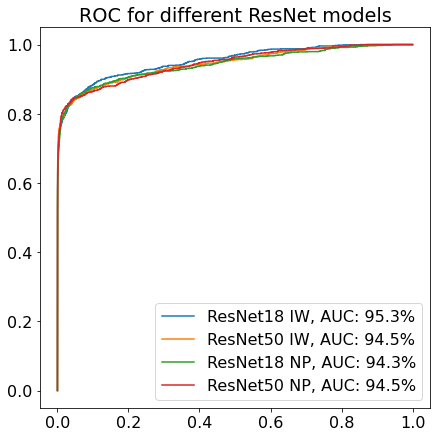

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib
positives = sum(y_tests)
negatives = len(y_tests) - positives
print(positives, negatives)
auc_s = []
font = {'family' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.figure(figsize=(7,7))

for i in range(0,4):
  fpr, tpr, thresholds = roc_curve(y_tests,predictions_five[i])
  
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print(optimal_idx)
  print("threshold:", optimal_threshold)
  print("precision is ", fpr[optimal_idx], "so it's ", fpr[optimal_idx]*negatives, "FP detected")
  print("while recall is ", tpr[optimal_idx], "so it's ", tpr[optimal_idx]*positives, "TP detected")
  auc_score_3 = roc_auc_score(y_tests,predictions_five[i])
  print(auc_score_3)
  auc_s.append(auc_score_3)

  plt.plot(fpr, tpr)

plt.legend(["ResNet18 IW, AUC: %.1f%%" % (auc_s[0]*100),
            "ResNet50 IW, AUC: %.1f%%" % (auc_s[1]*100),
            "ResNet18 NP, AUC: %.1f%%" % (auc_s[2]*100),
            "ResNet50 NP, AUC: %.1f%%" % (auc_s[3]*100)])
plt.title('ROC for different ResNet models')
#plt.show()
plt.savefig('drive/My Drive/models/'+ str(datetime.datetime.now()) + '.svg') 
